# Credit Card Fraud Classification

In this notebook, I will focus on classification of credit card fraud using the dataset available at Kaggle.com.  Due to the nature of the information, the parameters are not named, nor any identifying information concerning the clients are contained.

These variables are the result of Principle Component Analysis on the original dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.read_csv('creditcard.csv')
print(df.shape)

(284807, 31)


In [2]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


First, it would be necessary to check the balance of classifications (fraudulent vs. non-fraudulent).  This will inform many of our results and allow us to appropriately determine the accuracy of our models.

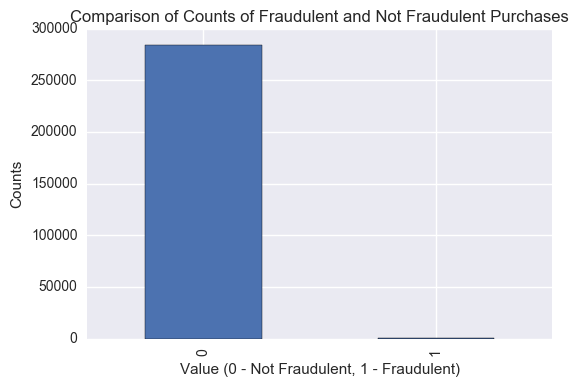

In [3]:
pd.value_counts(df['Class'],sort=True).sort_index().plot(kind='bar');
plt.xlabel("Value (0 - Not Fraudulent, 1 - Fraudulent)")
plt.ylabel("Counts")
plt.title("Comparison of Counts of Fraudulent and Not Fraudulent Purchases")

From this, we see that we have a terribly unbalanced data set.  This presents us with several issues, including accurately assessing the accuracy of the models.  This is actually referred to as the [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox).  Because we have this imbalance, it requires us to approach modelling in a slightly different way.

The variations from the more traditional, balanced data view are:
1. **Collect more data** - This has the potential to result in a more balanced data set.  However, in this case, we don't really have that option.
2. **Altering Metrics** - Instead of using the more traditional accuracy metric, we can use several other options.    
    * Confusion Matrix
    * Precision
    * Recall
    * F1 Score (F-Score)
    * Cohen's Kappa
    * ROC Curves
3.  **Dataset Resampling**
    * [Oversampling or Undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)
    * [Stratified Sampling](https://en.wikipedia.org/wiki/Stratified_sampling)
    * Alter Sampling Ratios
4.  **Generating Synthetic Samples**
5.  **Different Algorithms**
6.  **Penalized Models**
7.  **Different Perspectives**

## Normalizing Data
Before we approach the modelling of our data, let's check to make sure our data is normalized.  We will do this by determining the skewness of each of our parameters (excluding *Time* and *Class*).  Typically, a cut-off *Skew* value of greater than 0.75 suggests the need for normalizing of the column.

In [4]:
columnNames = list(df.drop(['Amount','Time','Class'],axis=1).columns.values)
print(columnNames)
dfNorm = df[['Time','Amount','Class']]

for column in columnNames:
    if df[column].skew() > 0.75:
        print("Skewed Column {}".format(column))
        dfNorm[column] = (df[column] - df[column].mean())/df[column].std()
    else:
        dfNorm[column] = df[column]

dfNorm.describe()

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Skewed Column V6
Skewed Column V7


C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Skewed Column V10
Skewed Column V21
Skewed Column V28


,Time,Amount,Class,V1,V2,V3,V4,V5,V6,V7,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,284807.000000,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,88.349619,0.001727,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,-2.227124e-16,1.663279e-15,...,9.049732e-16,5.085503e-16,1.850826e-17,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-3.725646e-17
std,47488.145955,250.120109,0.041527,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.000000e+00,1.000000e+00,...,8.140405e-01,7.709250e-01,1.000000e+00,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,1.000000e+00
min,0.000000,0.000000,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-1.963602e+01,-3.520933e+01,...,-7.213527e+00,-5.449772e+01,-4.741898e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-4.674604e+01
25%,54201.500000,5.600000,0.000000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-5.766811e-01,-4.478852e-01,...,-4.562989e-01,-2.117214e-01,-3.109428e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-1.604437e-01
50%,84692.000000,22.000000,0.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.058043e-01,3.241718e-02,...,3.734823e-03,-6.248109e-02,-4.009422e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,3.406362e-02
75%,139320.500000,77.165000,0.000000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.991620e-01,4.611099e-01,...,4.589494e-01,1.330408e-01,2.537387e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,2.371521e-01
max,172792.000000,25691.160000,1.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,5.502005e+01,9.747807e+01,...,5.591971e+00,3.942090e+01,3.703465e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,1.025432e+02


So we've corrected for skewed values.  Now lets test over and under sampling measures along with simple logistic regression.

## Over-sampling the Minority Class

In this case, we can sample (with replacement) from our Minority Class (Fraudulent in this case).  This results in a large number of copies of our minority class.

We will also submit some function definitions that will output ROC-Curves, and Confusion Matrices for comparisons.

In [5]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_ROC(y_test,decFunc):
    fpr, tpr, thresholds = roc_curve(y_test,decFunc)

    roc_auc = auc(fpr,tpr)

    # Plot ROC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_comparisons(X_test,y_test,decFunc, cm, classes):
    plt.figure()
    plot_ROC(y_test,decFunc)
    plt.figure()
    plot_confusion_matrix(cm, classes)
    plt.figure()
    plot_confusion_matrix(cm, classes,normalize=True)
    
dfOverSampling = dfNorm[dfNorm['Class']==1].sample(n=284315,replace=True)
dfOverSampling = dfOverSampling.append(dfNorm[dfNorm['Class']==0])
dfOverSampling = dfOverSampling.sample(frac=1).reset_index(drop=True)  


In [6]:
X_train, X_test, y_train, y_test = train_test_split(dfOverSampling.drop('Class',axis=1),\
                                                   dfOverSampling['Class'],test_size=0.33,random_state=42)

c_params = [0.001,0.01,0.1,0.5,1.0,10]
lrCV = LogisticRegressionCV(Cs=c_params,penalty='l1',solver='liblinear')
lrCV.fit(X_train,y_train)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 0.5, 1.0, 10], class_weight=None,
           cv=None, dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

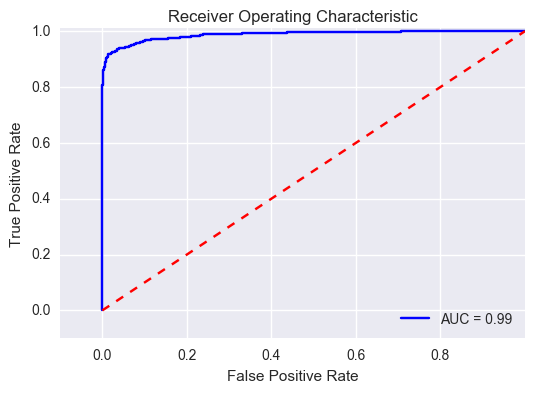

Confusion matrix, without normalization
[[91814  2020]
 [ 7328 86486]]
Normalized confusion matrix
[[ 0.97847262  0.02152738]
 [ 0.07811201  0.92188799]]


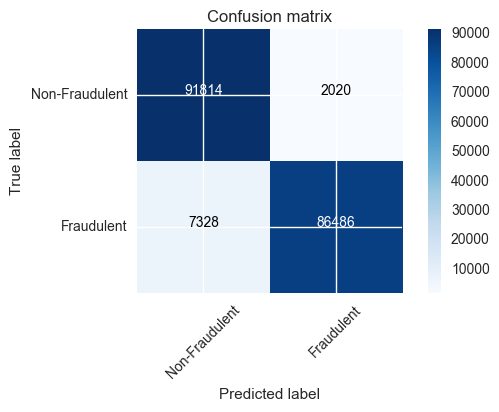

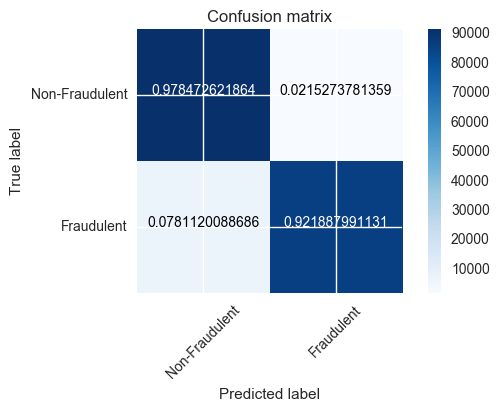

In [7]:
y_pred = lrCV.predict(X_test)
class_names = ['Non-Fraudulent','Fraudulent']
plot_comparisons(X_test,y_test,lrCV.decision_function(X_test),confusion_matrix(y_test, y_pred),classes=class_names)

Although our accuracy is unbalanced when compared to the imbalance in the data (>99% of the data is non-fraudulent), our model is significantly more generalizeable as it accurately predicts both fraudulent and non-fraudulent transactions.

In this model, our **LogisticRegressionCV()** function performs cross-validation via *Stratified KFold sampling*, which preserves the percentage of classes in each Fold.  In this case, it was a 50-50 split.  Let's see how using stratified sampling on our original data set would look.

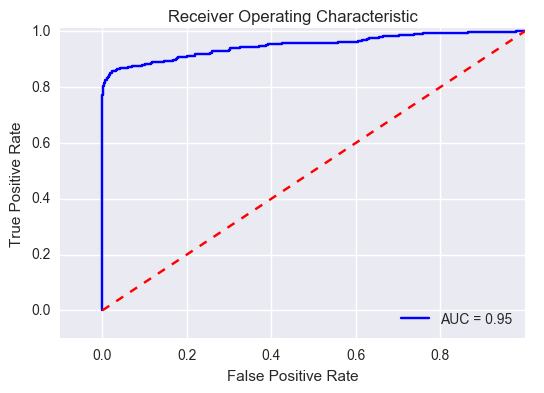

Confusion matrix, without normalization
[[190443     34]
 [   103    240]]
Normalized confusion matrix
[[  9.99821501e-01   1.78499241e-04]
 [  3.00291545e-01   6.99708455e-01]]


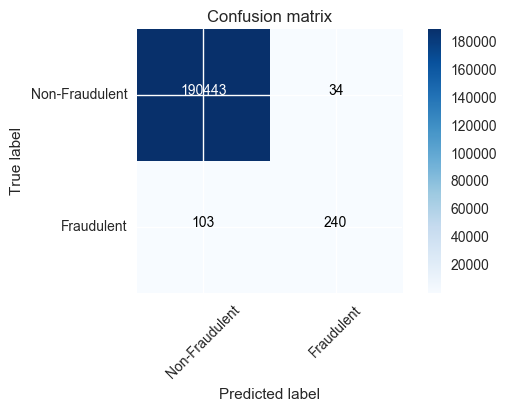

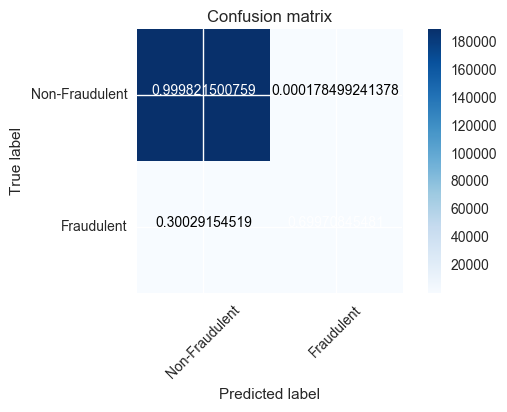

In [8]:
lrCVStrat = LogisticRegressionCV(Cs=c_params)
X_test, X_train, y_test, y_train = train_test_split(dfNorm.drop('Class',axis=1),\
                                                   dfNorm['Class'],test_size=0.33,random_state=42)
lrCVStrat.fit(X_train,y_train)
y_pred = lrCVStrat.predict(X_test)

plot_comparisons(X_test,y_test,lrCVStrat.decision_function(X_test),confusion_matrix(y_test, y_pred),classes=class_names)

# Further Modelling 

From this point, we've seen that stratification, and resampling produce results that are pretty darn good.  From here however, we're going to begin investigating other methods of binary classification.  This will include such popular topics as:
1.  Bayesian Classifer
2.  Decision Trees

## Bayesian Classifiers

Naive Bayesian classfiers are based on Bayes Theorem.  These methods are considered naive, as they assume independence between features, which is rarely the case of course.  The basis of the Bayesian approach is through bayes theorem:

$$ P(y|x_1, ..., x_n) = \frac{ P(y) P(x_1,....,x_n|y)}{ P(x_1,...,x_n }$$:

The naive bayes assumption comes in the form of:

$$ P(x_i | y, x_1, ... , x_{i+1},...x_n) = P(x_i | y) $$

$$ P( y | x_1, ..., x_n ) = \frac{P(y) \prod_{i=1}^{n} P(x_i|y) }{ P(x_1,...,x_n) }$$

$$ \hat{y} = arg\ max\ [\ P(y) \prod_{i=1}^{n} P(x_i|y)\ ]$$


For this classification, we will use the Gaussian Naive Bayes assumption, where:

$$ P(x_i | y ) = \frac{1}{\sqrt{2 \pi \sigma_y^2}}\ exp(-\frac{(x_i -\mu)^2}{2 \sigma_y^2})$$

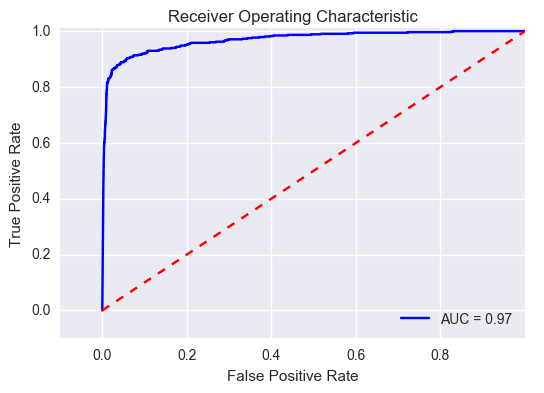

Confusion matrix, without normalization
[[92979   855]
 [26127 67687]]
Normalized confusion matrix
[[ 0.99088816  0.00911184]
 [ 0.27849788  0.72150212]]


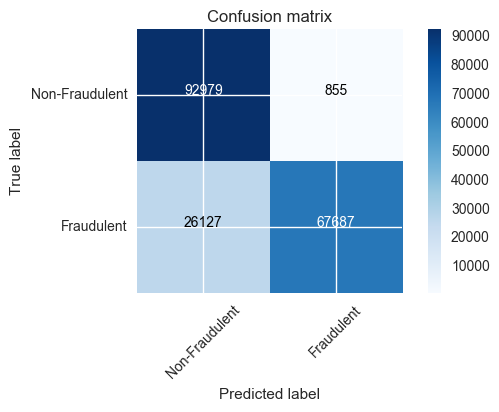

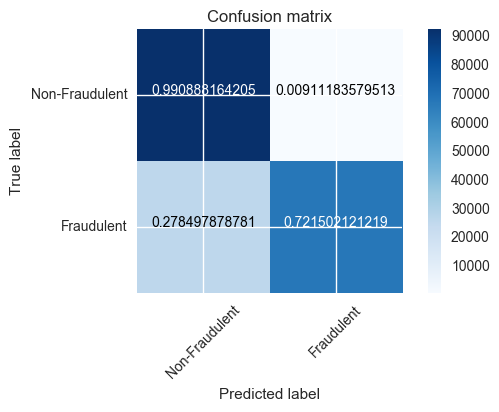

In [9]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(dfOverSampling.drop('Class',axis=1),\
                                                   dfOverSampling['Class'],test_size=0.33,random_state=42)

gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)

plot_comparisons(X_test,y_test,gnb.predict_proba(X_test)[:,1],confusion_matrix(y_test, y_pred),classes=class_names)

We see from here, that the Naive Bayes approach isn't quite as good as our regularized logistic regression that we started with.  The probability of correctly identifying Non-fraudulent transactions is only approximately as good as chance on our data set, and the probability of detecting fraudulent transactions is significantly less impressive.  

This just goes to show, in some cases, more complexity is not as effective.

## Decision Tree

Decision trees attempted to classify our objects through successive reduction in the output parameters.  Decision trees are analagous to how one might make a decision on what to make for breakfast (silly example but it gets the point across).

eg.
If eggs > 4:<br>
    eggs = omellette <br>
else if eggs < 4 and eggs >=2:<br>
    eggs = scrambled<br>
Else:<br>
    eggs = fried<br>
    
In a more numerical or perhaps abstract sense, decision trees compute information criterion for each parameter in order to make each decisions.  These include the Gini Impurity,

$$  I_G(f) = \sum_{1}^{J}{(f_i \ (1 - f_i)}  $$

the Information Gain,

$$ Gain = Entropy(parent)\ -\ Weighted\ Sum\ of\ Entropy(Children)$$

$$ IG(T,a) = H(T) - H(T|a) $$

or the Variance Reduction,

$$ I_V(N) = \frac{1}{\mid S \mid^2} \underset{i\in S}{\sum}\underset{j\in S}{\sum}\frac{1}{2}(x_i - x_j)^2 - \bigg(\frac{1}{\mid S_t \mid^2} \underset{i\in S_t}{\sum}\underset{j\in S_t}{\sum}\frac{1}{2}(x_i - x_j)^2 + \frac{1}{\mid S_f \mid^2} \underset{i\in S_f}{\sum}\underset{j\in S_f}{\sum}\frac{1}{2}(x_i - x_j)^2\bigg)$$

Specifically variance reduction is used in the CART algorithm, and is often employed when the target is continuous.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import  cross_val_score

def visualize_tree(tree, feature_names, fn="dt"):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn Decision Tree.
    feature_names -- list of feature names.
    fn -- [string], root of filename, default `dt`.
    """
    dotfile = fn + ".dot"
    pngfile = fn + ".png"

    with open(pngfile, 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", dotfile, "-o", pngfile]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, "
             "to produce visualization")
        


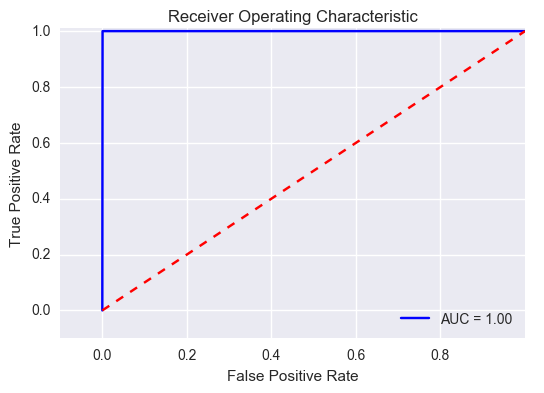

Confusion matrix, without normalization
[[93779    55]
 [    0 93814]]
Normalized confusion matrix
[[  9.99413859e-01   5.86141484e-04]
 [  0.00000000e+00   1.00000000e+00]]


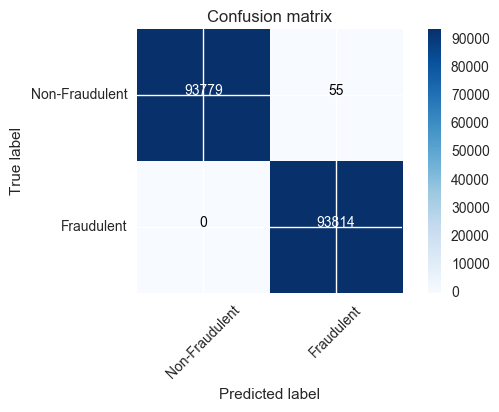

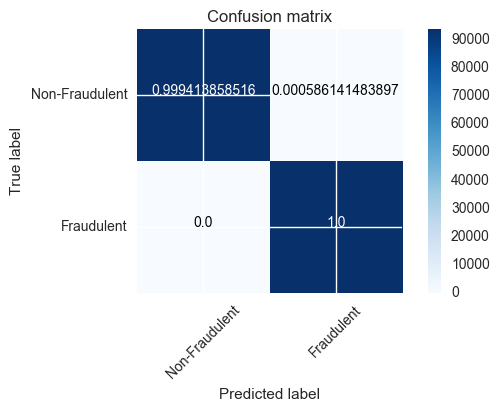

In [11]:
#param_grid = {"criterion": ["gini", "entropy"],
#              "min_samples_split": [2, 10, 20],
#              "max_depth": [None, 2, 5, 10],
#              "min_samples_leaf": [1, 5, 10],
#              "max_leaf_nodes": [None, 5, 10, 20],
#              }

dt = DecisionTreeClassifier()
#gridSearch = GridSearchCV(dt,param_grid=param_grid,cv=5)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

plot_comparisons(X_test,y_test,dt.predict_proba(X_test)[:,1],confusion_matrix(y_test, y_pred),classes=class_names)